#**Sentiment Analysis**

Sentiment analysis tries to capture subjective aspects in texts,
e.g., whether a tweet on Twitter shows a positive or negative mood of the author. Sentiment analysis is a text classification problem.
The difference to topic identification is that in sentiment analysis, we do not want to classify our documents by objective aspects (e.g., by
topics) but to get an idea of the subjective aspects in the text (e.g., positive or negative
feedback) [[1]](#scrollTo=P4arl7P3xUuB).

This notebook shows examples of sentiment analysis with ``simpletransformers`` [[2]](https://simpletransformers.ai/about/).


## **Sentiment analysis with ``simpletransformers``**

In this section, We show how to train and evaluate our own sentiment analysis model using the ``simpletransformers`` library and the Stanford’s large movie review dataset [[3]](https://ai.stanford.edu/~amaas/data/sentiment/).



This dataset contains 50,000 annotated movie reviews: 25,000 reviews in the training set
and another 25,000 reviews in the test set. Each review consists of text data including
HTML tags for line breaks and a label that can be either “positive” or “negative.” The
data is extracted from IMDb. IMDb uses a scoring system for the reviews. If the score is
less than or equal to 4 out of 10, a review is labeled “negative”; scores greater than or
equal to 7 are labeled “positive.” Reviews that receive between 4 and 7 points are considered neutral and not included in the dataset [[1]](#scrollTo=P4arl7P3xUuB).



We perform the following steps:
* Install the ``simpletransformers`` library
* Import other libraries and packages; ``pandas``, ``ClassificationModel``, ``train_test_split``and ``preprocessing``
* Download dataset from Kaggle
* Create a general classification model
* Fine-tune the general model
* Evaluate the fine-tuned model
* Make predictions for a given text

### Install ``simpletransformers``

First, we install the ``simpletransformers`` library. This library is based on the Hugging Face transformers library [[4]](https://huggingface.co/docs/transformers/index). ``simpletransformers`` helps us to quickly train and evaluate transformer models. For more details about the ``simpletransformers`` library, please refer to [[2]](https://simpletransformers.ai/about/).


In this notebook, we use the following functions of the ``simpletransformers``library:
* ``ClassificationModel()`` to create a general classification model
* ``train_model()`` to fine-tune the general model
* ``eval_model()`` to evaluate the fine-tuned model
* ``predict()`` to make predictions for a given text



**Note:**<br>
Deep Learning (DL) models typically run on CUDA-enabled GPUs as the performance is better compared to running on a CPU [[5]](https://simpletransformers.ai/docs/usage/#enablingdisabling-cuda). CUDA is a parallel computing platform created by NVIDIA.

On all ``simpletransformers`` models, CUDA is enabled by default. Because of that, in order to proceed, we should enable CUDA in our GPU. If we use Google Colab, we do not need to do anything since CUDA is pre-installed. But we need to enable the GPU in our Colab top menu by clicking on "Runtime/Change runtime type" and choosing "GPU".
 
In order to proceed without CUDA, we run the following code snippets until we can disable CUDA in ["Create classification model"](#scrollTo=DmfjRTC21KCt).

In [1]:
# Install the simpletransformers library
# Important: If you see a button "RESTART RUNTIME" after installing simpletransformers, click on this button to restart the runtime.
!pip install simpletransformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 249 kB 6.6 MB/s 
     |████████████████████████████████| 6.6 MB 50.7 MB/s 
     |████████████████████████████████| 9.1 MB 57.9 MB/s 
     |████████████████████████████████| 1.8 MB 58.7 MB/s 
     |████████████████████████████████| 365 kB 45.1 MB/s 
     |████████████████████████████████| 4.4 MB 50.0 MB/s 
     |████████████████████████████████| 1.2 MB 60.2 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 596 kB 48.7 MB/s 
     |████████████████████████████████| 101 kB 9.3 MB/s 
     |████████████████████████████████| 153 kB 61.5 MB/s 
     |████████████████████████████████| 181 kB 55.9 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 212 kB 59.6 MB/s 
     |████████████████████████████████| 1.1 MB 52.8 MB/s 
     |███████████████████████████████

### Import libraries and packages

### Import libraries and packages
We import all necessary libraries: In addition to ``simpletransformers``,
we need functions from ``sklearn`` and ``pandas`` to process our dataset. For more details about the ``sklearn`` and ``pandas`` libraries, please refer to [[6]](https://scikit-learn.org/stable/) and [[7]](https://pandas.pydata.org/).


In [38]:
# Import the pandas and numpy libraries
import pandas as pd
import numpy as np

# Import the "ClassificationModel" package for text classification tasks
from simpletransformers.classification import ClassificationModel

import sklearn

# Import the "train_test_split" function from the sklearn library
from sklearn.model_selection import train_test_split

# Import the "preprocessing" package from sklearn
from sklearn import preprocessing

# Import the "preprocessing" package from sklearn EDIT EDIT#######
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Import pyplot from matplotlib library to plot label distribution
from matplotlib import pyplot as plt

# import the 're' module to remove the HTML-tags during the data cleaning step
import re

### Download dataset

#### 1- Create folder
We create a Kaggle folder in Colab to download dataset from [https://ai.stanford.edu](https://ai.stanford.edu/~amaas/data/sentiment/)

In [2]:
# Prepare folders in the colab environment
import os

os.mkdir('/content/data')

In [3]:
# Change current directory
os.chdir('/content/data')

#### 2- Download and unpack dataset

Since the dataset ``aclImdb_v1.tar.gz`` is compressed in zip format, we download and extract it.

In [4]:
# Download dataset
!curl -O --location https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  61.6M      0  0:00:01  0:00:01 --:--:-- 61.6M


In [5]:
 # Extract dataset
!tar -xf aclImdb_v1.tar.gz

In [6]:
# Get back to default ('content/') location
os.chdir('..')

### Data preparation
As explained before, our dataset contains 50,000 movie reviews. It is divided evenly into 25.000 reviews for training set and 25.000 reviews for testing set . The labels are balanced between the two classes (positive and negative). That means, we have 12.500 positive reviews and 12.500 negative reviews for each set.

If we check the downloaded dataset, we see that each review is a seperate ``txt`` file. The positive reviews are located in the ``pos`` folder and negative reviews are located in the ``neg`` folder. 

For our classification model, we should combine all positive and negative review files into 1 pandas DataFrame representing the train dataset. We do the same process for test dataset.

#### Define a function to combine ``txt`` files
We create a function to add all ``txt`` files into one list for the given ``file_folder``.

This function creates returns 2 lists, ``labels`` and ``data``. The list ``labels`` contains the labels of review, ``0`` for negative and ``1`` for positive sentiments. The list ``data`` contains all reviews as ``str``(string).

In [7]:
# Define a function to add all single text-file contents into one list
def get_appendedData(file_folder):
  data, labels = [], []

  for label in ('neg', 'pos'):
    folder_name = os.path.join(file_folder, label)
    
    for file in os.listdir(folder_name):
      with open(os.path.join(folder_name, file), 'rb') as f:

        review = f.read().decode('utf-8').replace('\n', '')
        data.append(review)
        labels.append(1 if label == 'pos'else 0)

  return data, labels

#### Create train and test sets

In [20]:
train_folder = '/content/data/aclImdb/train'
test_folder = '/content/data/aclImdb/test'

train_data = get_appendedData(train_folder)
test_data = get_appendedData(test_folder)

In [21]:
train_df = pd.DataFrame(train_data).transpose()
train_df.columns = ['review', 'label']

test_df = pd.DataFrame(test_data).transpose()
test_df.columns = ['review', 'label']

#### Check content of datasets
We have created the test and training sets. However, before we proceed, we should check the content of the datasets and decide if they contain any unwanted data.

##### Print first 3 rows
First we print the first 3 reviews of the train and test datasets with the ``head()`` function.

In [22]:
train_df.head(3)

,review,label
0,"Brides are dying at the altar, and their corps...",0
1,Cliff Robertson as a scheming husband married ...,0
2,"..IT'S THIS ONE! Very cool premise, right off ...",0


In [23]:
test_df.head(3)

,review,label
0,Apparently SHRUNKEN HEADS was the last movie t...,0
1,Any movie should have an idea; Simple or more ...,0
2,I doubt whoever wrote this screenplay has ever...,0


##### Visualize label distribution

We should have 12500 positive and 12500 negative reviews for each dataset. We plot the label distribution with the ``matplotlib`` library.

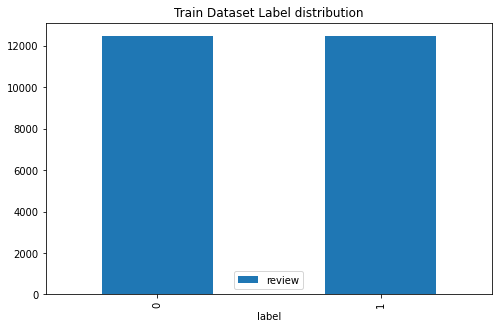

In [24]:
# Plot a bar chart and display label distribution of the train dataset
ax = train_df.groupby("label").count().plot(kind="bar", 
                                                 figsize=(8, 5),
                                                 title="Train Dataset Label distribution")
plt.show()

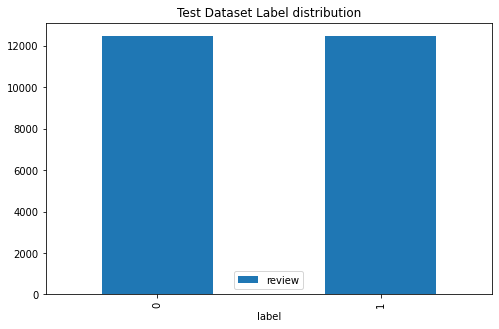

In [25]:
# Plot a bar chart and display label distribution of the test dataset
ax = test_df.groupby("label").count().plot(kind="bar", 
                                                 figsize=(8, 5),
                                                 title="Test Dataset Label distribution")
plt.show()

##### Check content of reviews

We have not seen any problem so far. The label distribution is as we wanted. Now we print a review and check its content to decide if it contains any unwanted data.

In [26]:
# Print the first review of the train dataset
print(train_df["review"][0])

Brides are dying at the altar, and their corpses are disappearing. Everybody is concerned, but nobody seems to be able to figure out why and how this is happening, nor can they prevent it from happening. Bear with me. Bela Lugosi is responsible for this, as he is extracting spinal fluid from these young women to transfuse his ancient wife and keep her alive. Continue to bear with me. Finally, the authorities figure out that somebody must be engineering the deaths and disappearances, but of course, they can't figure out the improbable motive. Let's just ignore the ludicrous pseudoscience and move on... If you can get through the first twenty minutes of this mess, you will be treated to Lugosi whipping his lab assistant for disrespecting one of the brides he has murdered, explaining that he finds sleeping in a coffin much more comfortable than a bed, and other vague parodies of real horror films (the kind with budgets and plots). Anyhoo - a female journalist follows her nose to the culpr

In [27]:
# Print the first review of the test dataset
print(test_df["review"][0])

Apparently SHRUNKEN HEADS was the last movie that Julius Harris had a role in. I have not seen all of his movies, but Julius Harris was in many good movies, and I remember him best from "Live and Let Die" where he played Tee-Hee and which was full of Voodoo references, something that is common here in South Florida! I always thought LIVE AND LET DIE was a great movie because it had some atmosphere and mystique, unlike most of the 007 movies. In SHRUNKEN HEADS, Julius Harris is back in his Voodoo persona! He has a great style for mystery and the occult, and his part in this movie is excellent. Sadly, the rest of the movie is something of a comedy. SPOILERS: Three kids who look like they were fired from the cast of THE LITTLE RASCALS get killed by a neighborhood hoodlum who looks like he got fired from the cast of FAME! or as a dancer on DICK CLARK'S AMERICAN BANDSTAND. In other words, these kids give LOW BUDGET another dimension. Julius Harris goes to the mortuary-Funeral Home, cuts off

As we see above, there are HTML-tags inside the reviews. These tags are irrelevant for our task and we should delete them to improve the performance of our classification model. 

#### Data Cleaning

In this step, we remove the HTML-tags from our datasets. For this, we use the ``re.compile()`` function of the ``re`` module. The ``re`` module is a built-in python package and  it provides a set of powerful regular expression facilities, which allows us to quickly check whether a given string matches a given pattern or contains such a pattern.
The following code is based on [[3]](https://stackoverflow.com/questions/9662346/python-code-to-remove-html-tags-from-a-string).

In [28]:
# Define and compile regular expressions to match HTML-tags
cleanhtml_re = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
cleanbrackets_re = re.compile('\[[^]]*\]')
cleanspecchar_re = re.compile(r'[^a-zA-z0-9\s]')

# Define a function which takes a raw text as input and returns it without HTML-tags as "cleantext"
def cleanhtml(rawtext):
  cleantext = re.sub(cleanhtml_re, ' ', rawtext)
  cleantext = re.sub(cleanbrackets_re,' ', cleantext)
  cleantext = re.sub(cleanspecchar_re, ' ', cleantext)
  return cleantext

In [29]:
# Remove HTML tags in train and test datasets
train_df['review'] = train_df['review'].apply(cleanhtml)
test_df['review'] = test_df['review'].apply(cleanhtml)

In [30]:
# Print the first review of the train dataset
print(train_df["review"][0])

Brides are dying at the altar  and their corpses are disappearing  Everybody is concerned  but nobody seems to be able to figure out why and how this is happening  nor can they prevent it from happening  Bear with me  Bela Lugosi is responsible for this  as he is extracting spinal fluid from these young women to transfuse his ancient wife and keep her alive  Continue to bear with me  Finally  the authorities figure out that somebody must be engineering the deaths and disappearances  but of course  they can t figure out the improbable motive  Let s just ignore the ludicrous pseudoscience and move on    If you can get through the first twenty minutes of this mess  you will be treated to Lugosi whipping his lab assistant for disrespecting one of the brides he has murdered  explaining that he finds sleeping in a coffin much more comfortable than a bed  and other vague parodies of real horror films  the kind with budgets and plots   Anyhoo   a female journalist follows her nose to the culpr

In [19]:
# Print the first review of the test dataset
print(test_df["review"][0])

Apparently SHRUNKEN HEADS was the last movie that Julius Harris had a role in I have not seen all of his movies but Julius Harris was in many good movies and I remember him best from Live and Let Die where he played TeeHee and which was full of Voodoo references something that is common here in South Florida I always thought LIVE AND LET DIE was a great movie because it had some atmosphere and mystique unlike most of the 007 movies In SHRUNKEN HEADS Julius Harris is back in his Voodoo persona He has a great style for mystery and the occult and his part in this movie is excellent Sadly the rest of the movie is something of a comedy SPOILERS Three kids who look like they were fired from the cast of THE LITTLE RASCALS get killed by a neighborhood hoodlum who looks like he got fired from the cast of FAME or as a dancer on DICK CLARKS AMERICAN BANDSTAND In other words these kids give LOW BUDGET another dimension Julius Harris goes to the mortuaryFuneral Home cuts off the three kids heads an

### Create classification model
Now our datasets are ready for training and evaluation processes. First we create our classification model. We use the ``bert_base_uncased`` model from the ``bert`` model family. The number of labels (categories) is set to 2 as we want to differ positive and negative reviews.

**NOTE:** 
On all ``simpletransformers`` models, CUDA is enabled by default which is recommended. If a system is not able to operate with CUDA, we can disable it. Below we find code for both options.

Option-1: With CUDA (Recommended)

In [31]:
# Create a classification model
## We will use 'bert' classification model
## We choose "uncased" (lowercase) bert model
## num_labels specifies he number of labels or classes in the dataset

model = ClassificationModel('bert', 'bert-base-uncased', num_labels=2)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Option-2: Without CUDA


In [ ]:
# Run this code to only disable CUDA:

#model = ClassificationModel('bert',
#                            'bert-base-uncased',
#                            num_labels=len(labels),
#                            use_cuda=False))

### Train model
We can start training our model. This automatically downloads the pre-trained
BERT model, initializes its parameters, and preprocesses our training data using a
subword tokenizer before the actual training process is started [[1]](#scrollTo=P4arl7P3xUuB).

In [32]:
# Train the model
model.train_model(train_df)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:602: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/25000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/3125 [00:00<?, ?it/s]

(3125, 0.3763799653625488)

### Evaluation
We evaluate the model by using our evaluation set.

In [33]:
# Evaluate the model
result, model_outputs, predictions = model.eval_model(test_df)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/25000 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/3125 [00:00<?, ?it/s]

In [34]:
print(result)

{'mcc': 0.775342924380947, 'tp': 11215, 'tn': 10975, 'fp': 1525, 'fn': 1285, 'auroc': 0.9561946048, 'auprc': 0.9517564370072562, 'eval_loss': 0.3137754592895508}


In [40]:
# Print accuracy and F1 score
## Create a list "predicted" and append predicted labels
predicted = []
for arr in model_outputs:
    predicted.append(np.argmax(arr))

## Define a list "true" and assign true labels
true = test_df['label'].tolist()

## Calculate and print accuracy and F1 score
accuracy_score=sklearn.metrics.accuracy_score(true,predicted)
f1_score=sklearn.metrics.f1_score(true,predicted, average='weighted')
print("Accuracy: ",accuracy_score)
print("F1 Score: ",f1_score)

Accuracy:  0.8876
F1 Score:  0.8875896402612465


In [49]:
# Predict the label of a given movie review
## "0": Negative
## "1": Positive
prediction1, raw_outputs = model.predict(["It's a long movie with a lot of mystery. You need to watch it with a strong mind to understand it. It is one of the movies that surprised me at the end."])

# Print the predicted label
print("Predicted label: ",prediction1)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Predicted label:  [1]


In [50]:
# Predict the label of a given movie review
## "0": Negative
## "1": Positive
prediction1, raw_outputs = model.predict(["The same story, the same ending. I like romantic comedies, but this couple is just awkward."])

# Print the predicted label
print("Predicted label: ",prediction1)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Predicted label:  [0]


In [51]:
# Predict the label of a given movie review
## "0": Negative
## "1": Positive
prediction1, raw_outputs = model.predict(["It is a movie that I watched at the insistence of my friend on a day when I was very upset and made me laugh a lot in spite of that stress."])

# Print the predicted label
print("Predicted label: ",prediction1)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Predicted label:  [1]


# **References**

- [1] NLP and Computer Vision_DLMAINLPCV01 Course Book
- [2] https://simpletransformers.ai/docs/usage/#enablingdisabling-cuda
- [3] https://stackoverflow.com/questions/9662346/python-code-to-remove-html-tags-from-a-string


Copyright © 2022 IU International University of Applied Sciences